Zachary Armand

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import functional as F
from torch.utils.data import random_split
from torch.utils.data import DataLoader, TensorDataset

# Local import
from tools import train_model, evaluate_model, calculate_R2_score, get_predictions, best_hyperparameter_results, visualize_all_hyperparameter_results, EarlyStopping
from models import SimpleNet, BaseballRNN

In [13]:
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"))
print("Using:", DEVICE)

Using: cuda


In [14]:
#pip freeze > requirements.txt

# Load Data and Create Dataset

In [15]:
input_values = torch.load('./datasets/input_values.pth')
target_values = torch.load('./datasets/target_values.pth')

Dataset and dataloaders are used for both models.

In [16]:
# Create Dataset
dataset = TensorDataset(input_values, target_values)

# Split into test and train data
train_dataset, test_dataset = random_split(dataset, [0.9, 0.1])
train_dataset, valid_dataset = random_split(train_dataset, [0.89, 0.11])
print(f"Train: {len(train_dataset)/len(dataset)*100:.1f}%, Test: {len(test_dataset)/len(dataset)*100:.1f}%, Valid: {len(valid_dataset)/len(dataset)*100:.1f}%")
print(f"Train: {len(train_dataset)}, Test: {len(test_dataset)}, Valid: {len(valid_dataset)}")

# Create consistent test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

Train: 80.1%, Test: 10.0%, Valid: 9.9%
Train: 57640, Test: 7195, Valid: 7123


In [17]:
# Convert datasets to tensors for easier manipulation
train_inputs = torch.stack([x[0] for x in train_dataset])
valid_inputs = torch.stack([x[0] for x in valid_dataset])
test_inputs = torch.stack([x[0] for x in test_dataset])

# Check the shape of the inputs to ensure it's 4D (e.g., (num_samples, channels, height, width))
print(f"Train inputs shape: {train_inputs.shape}")
print(f"Valid inputs shape: {valid_inputs.shape}")
print(f"Test inputs shape: {test_inputs.shape}")

# Store the original shape for later reshaping
original_shape = train_inputs.shape[1:]  # (channels, height, width) or whatever your original shape was

# Reshape the inputs to 2D (samples, features) for scaling
train_inputs_reshaped = train_inputs.view(train_inputs.size(0), -1)
valid_inputs_reshaped = valid_inputs.view(valid_inputs.size(0), -1)
test_inputs_reshaped = test_inputs.view(test_inputs.size(0), -1)

# Scale the inputs using StandardScaler (you could also use MinMaxScaler or another scaler)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Fit scaler on training data and transform
train_inputs_scaled = torch.tensor(scaler.fit_transform(train_inputs_reshaped.numpy()), dtype=torch.float32)

# Use the same scaler to transform the validation and test data
valid_inputs_scaled = torch.tensor(scaler.transform(valid_inputs_reshaped.numpy()), dtype=torch.float32)
test_inputs_scaled = torch.tensor(scaler.transform(test_inputs_reshaped.numpy()), dtype=torch.float32)

# Reshape the scaled inputs back to the original shape (samples, channels, height, width)
train_inputs_scaled = train_inputs_scaled.view(train_inputs.size(0), *original_shape)
valid_inputs_scaled = valid_inputs_scaled.view(valid_inputs.size(0), *original_shape)
test_inputs_scaled = test_inputs_scaled.view(test_inputs.size(0), *original_shape)

# Recreate the datasets with the scaled inputs
train_dataset = TensorDataset(train_inputs_scaled, torch.stack([x[1] for x in train_dataset]))
valid_dataset = TensorDataset(valid_inputs_scaled, torch.stack([x[1] for x in valid_dataset]))
test_dataset = TensorDataset(test_inputs_scaled, torch.stack([x[1] for x in test_dataset]))

# Create consistent test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

Train inputs shape: torch.Size([57640, 9, 15])
Valid inputs shape: torch.Size([7123, 9, 15])
Test inputs shape: torch.Size([7195, 9, 15])


# Simple Linear model

### MLP hyperparameter tuning

In [19]:
# Number of random combinations to sample
num_random_combinations = 150  

# Define hyperparameters to test
testing_params = {
    'batch_size': [16, 32, 64, 128, 256],
    'lr': [0.01, 0.001, 0.0001, 0.00001],
    'mlp_dropout': [0.0, 0.1, 0.25, 0.33, 0.5],
    'weight_decay': [0.0, 1e-2, 1e-3, 1e-4, 1e-5],
    'hidden_size': [8, 16, 64, 128, 256],
    'grad_clip': [None, 0.5, 1.0, 2.0]
}

'''# Create a list of all parameter combinations
param_combinations = [(batch_size, lr, mlp_dropout, weight_decay, hidden_size)
                      for batch_size in testing_params['batch_size']
                      for lr in testing_params['lr']
                      for mlp_dropout in testing_params['mlp_dropout']
                      for weight_decay in testing_params['weight_decay']
                      for hidden_size in testing_params['hidden_size']
                      ]'''

# Generate random combinations
random_param_combinations = [
    (
        random.choice(testing_params['batch_size']),
        random.choice(testing_params['lr']),
        random.choice(testing_params['mlp_dropout']),
        random.choice(testing_params['weight_decay']),
        random.choice(testing_params['hidden_size']),
        random.choice(testing_params['grad_clip'])
    )
    for _ in range(num_random_combinations)
]

# Save what parameters are being tested
mlp_hyperparam_testing = pd.DataFrame(random_param_combinations, columns=testing_params.keys())

In [20]:
results = {}
num_epochs = 150
early_stop_patience = 15
loss = 'MSE'

# Initialize tqdm progress bar to track progress through iterations
pbar = tqdm(random_param_combinations, desc="Training Models", total=len(random_param_combinations))

# Iterate over parameter combinations
for i, (batch_size, lr, mlp_dropout, weight_decay, hidden_size, grad_clip) in enumerate(pbar):

    # Turn dataset into Dataloaders
    valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

    # Create model
    in_features, seq_len = valid_dataloader.dataset[0][0].shape
    simple_baseball_mlp = SimpleNet(in_features=in_features, seq_len=seq_len, hidden_features=hidden_size, dropout=mlp_dropout).to(DEVICE)

    # Optimizer and early stopper
    optimizer = Adam(simple_baseball_mlp.parameters(), lr=lr, weight_decay=weight_decay)
    early_stopper = EarlyStopping(patience=early_stop_patience, min_delta=0.0001)

    # Training
    eval_log = []

    # Training loop
    for epoch in range(num_epochs):
        # Validation loss
        avg_valid_loss = train_model(simple_baseball_mlp, optimizer, valid_dataloader, DEVICE, loss_fn=loss, grad_clip=grad_clip)
        eval_log.append(avg_valid_loss)
    
        # Early Stopping
        early_stopper(avg_valid_loss)
        if early_stopper.early_stop:
            #print(f"Early stopping at epoch {epoch}")
            break    
    
    # Save results
    results[i] = [eval_log]

    # Test evaluation
    test_accuracy = evaluate_model(model=simple_baseball_mlp, data_loader=test_dataloader, device=DEVICE, loss_fn=loss)
    # Save results
    results[i].append(test_accuracy)
    results[i].append(f'Batch size: {batch_size}, lr: {lr}, dropout: {mlp_dropout}\n l2: {weight_decay}, hidden_size: {hidden_size}, grad_clip: {grad_clip}\n{loss}: {test_accuracy:.4}')
    # Append training epochs
    results[i].append(epoch+1)


Training Models: 100%|██████████| 150/150 [1:28:44<00:00, 35.50s/it]


Evaluate the models, first by lowest RSME. Also visualize results to make sure that they aren't overfitting.

6 best models (index and values):
(125, 0.1406137421654694)
(104, 0.14107490197248637)
(88, 0.14109431253364302)
(120, 0.14120932422303922)
(82, 0.14127558633177706)
(65, 0.14137204522635888)


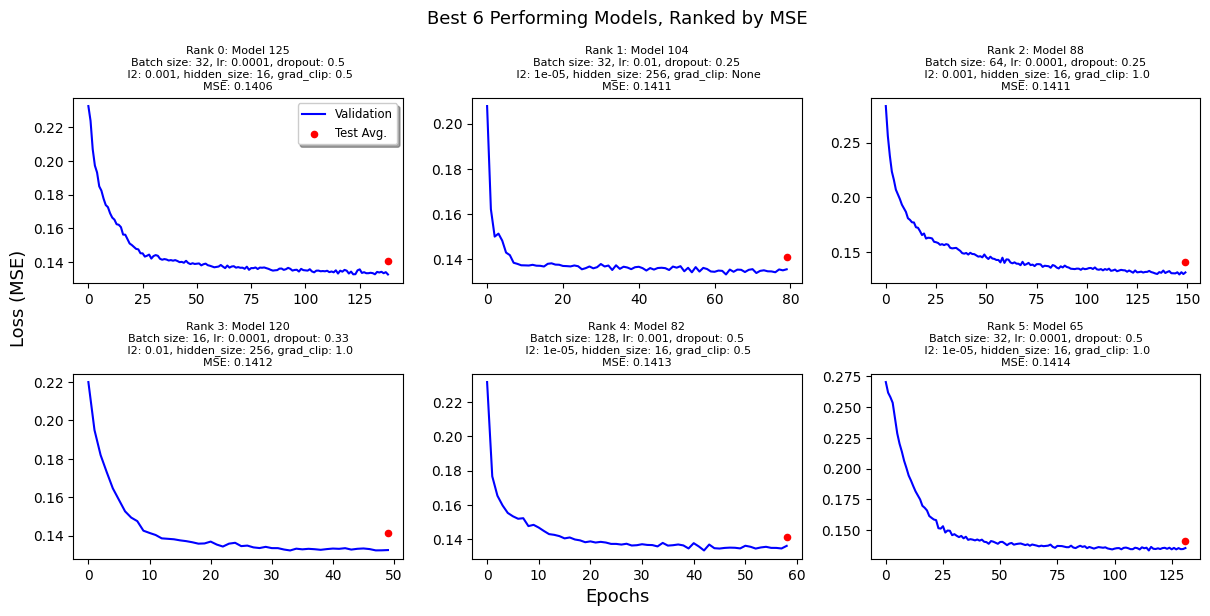

In [21]:
best_hyperparameter_results(results, loss=loss, n_best=6)

In [22]:
#visualize_all_hyperparameter_results(results, loss=loss)

In [23]:
# Save full results to csv
mlp_hyperparam_testing['result_variance'] = [np.var(results[i][0]) for i in results]
mlp_hyperparam_testing['tuning_epochs'] = [results[i][3] for i in results]
mlp_hyperparam_testing[f'tuning_loss_{loss}'] = [results[i][1] for i in results]
mlp_hyperparam_testing.to_csv('./tuning/mlp_hyperparameter_tuning.csv')

In [ ]:
min_index = mlp_hyperparam_testing['tuning_loss_MSE'].idxmin()
best_mlp_params = mlp_hyperparam_testing.iloc[min_index].to_dict()
print("Best MLP Parameters:")
for key in best_mlp_params:
    print(f"{key}: {best_mlp_params[key]}")

Best MLP Parameters:
batch_size: 32.0
lr: 0.0001
mlp_dropout: 0.5
weight_decay: 0.001
hidden_size: 16.0
grad_clip: 0.5
result_variance: 0.00028095578763504887
tuning_epochs: 139.0
tuning_loss_MSE: 0.1406137421654694


# RNN Network

A many-to-one RNN using gated recurrence units (GRUs)

In [ ]:
# Number of random combinations to sample
num_random_combinations = 150  

# Define hyperparameters to test
testing_params = {
    'batch_size': [16, 32, 64, 128, 256],
    'n_layers': [1, 2, 3],
    'lr': [0.01, 0.001, 0.0001, 0.00001],
    'rnn_dropout': [0.0, 0.1, 0.2, 0.33, 0.5],
    'weight_decay': [0.0, 1e-2, 1e-3, 1e-4, 1e-5],
    'grad_clip': [None, 0.5, 1.0, 2.0],
    'hidden_size': [8, 16, 64, 128, 256],
}

'''# Create a list of all parameter combinations
param_combinations = [(batch_size, n_layers, lr, rnn_dropout, weight_decay, grad_clip)
                      for batch_size in testing_params['batch_size']
                      for n_layers in testing_params['n_layers']
                      for lr in testing_params['lr']
                      for rnn_dropout in testing_params['rnn_dropout']
                      for weight_decay in testing_params['weight_decay']
                      for grad_clip in testing_params['grad_clip']
                      ]'''

# Generate random combinations
random_param_combinations = [
    (
        random.choice(testing_params['batch_size']),
        random.choice(testing_params['n_layers']),
        random.choice(testing_params['lr']),
        random.choice(testing_params['rnn_dropout']),
        random.choice(testing_params['weight_decay']),
        random.choice(testing_params['grad_clip']),
        random.choice(testing_params['hidden_size'])
    )
    for _ in range(num_random_combinations)
]

# Save what parameters are being tested
rnn_hyperparam_testing = pd.DataFrame(random_param_combinations, columns=testing_params.keys())

In [ ]:
results_rnn = {}
num_epochs = 150
early_stop_patience = 15
loss = 'MSE'

# Initialize tqdm progress bar to track progress through 144 iterations
pbar = tqdm(random_param_combinations, desc="Training Models", total=len(random_param_combinations))

# Iterate over parameter combinations
for i, (batch_size, n_layers, lr, rnn_dropout, weight_decay, grad_clip, hidden_size) in enumerate(pbar):

    # Turn into Dataloaders
    valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    # Create model
    input_size = valid_dataloader.dataset[0][0].size()[1]
    baseball_rnn = BaseballRNN(input_size=input_size, output_size=1, hidden_size=hidden_size,
                                    n_layers=n_layers, hidden_init='rand', rnn_dropout=rnn_dropout).to(DEVICE)

    # Optimizer and early stopping
    optimizer = Adam(baseball_rnn.parameters(), lr=lr, weight_decay=weight_decay)
    early_stopper = EarlyStopping(patience=early_stop_patience, min_delta=0.0001)

    # Training
    eval_log_rnn = []
    for epoch in range(num_epochs):
        
        # Validation loss
        avg_valid_loss = train_model(baseball_rnn, optimizer, valid_dataloader, DEVICE, loss_fn=loss, grad_clip=grad_clip)
        eval_log_rnn.append(avg_valid_loss)
        # Early Stopping
        early_stopper(avg_valid_loss)
        if early_stopper.early_stop:
            #print(f"Early stopping at epoch {epoch}")
            break    

    # Save results
    results_rnn[i] = [eval_log_rnn] 

    # Test evaluation
    test_accuracy_rnn = evaluate_model(model=baseball_rnn, data_loader=test_dataloader, device=DEVICE, loss_fn=loss)
    # Save results
    results_rnn[i].append(test_accuracy_rnn)
    results_rnn[i].append(f'Batch size:{batch_size}, lr:{lr}, n_layers:{n_layers}, dropout:{mlp_dropout}\n l2:{weight_decay}, hidden_size:{hidden_size}, grad_clip:{grad_clip}\n{loss}: {test_accuracy_rnn:.4}')

    # Append training epochs
    results_rnn[i].append(epoch+1)


Training Models:   2%|▏         | 3/150 [00:56<48:04, 19.62s/it]c:\Users\Zachary\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
Training Models:   6%|▌         | 9/150 [04:18<1:48:21, 46.11s/it]c:\Users\Zachary\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
Training Models:  22%|██▏       | 33/150 [21:14<54:27, 27.93s/it]  c:\Users\Zachary\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers gre

6 best models (index and values):
(28, 0.13944285819106336)
(24, 0.1397597216727255)
(110, 0.13984562802057948)
(95, 0.140118790588253)
(148, 0.14092871251000225)
(141, 0.14093793981124164)


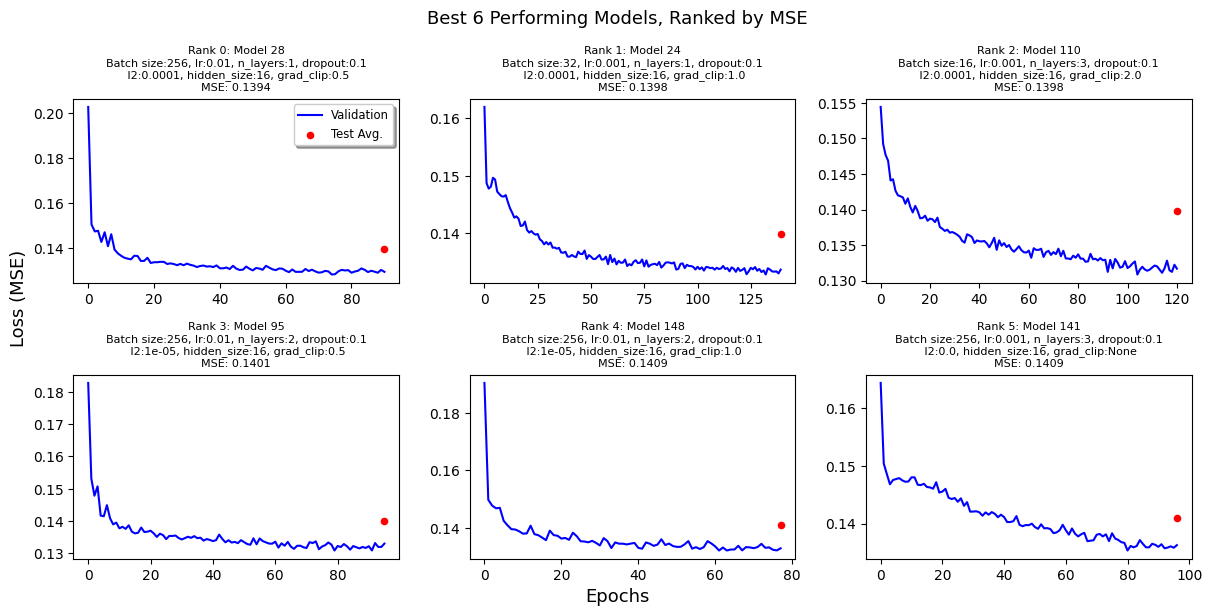

In [27]:
best_hyperparameter_results(results_rnn, loss=loss, n_best=6)

In [28]:
#visualize_all_hyperparameter_results(results_rnn, loss=loss)

In [29]:
# Save full results to csv
rnn_hyperparam_testing['tuning_epochs'] = [results_rnn[i][3] for i in results_rnn]
rnn_hyperparam_testing[f'tuning_loss_{loss}'] = [results_rnn[i][1] for i in results_rnn]
rnn_hyperparam_testing.to_csv('./tuning/rnn_hyperparameter_tuning.csv')

In [49]:
min_index = rnn_hyperparam_testing['tuning_loss_MSE'].idxmin()
best_rnn_params = rnn_hyperparam_testing.iloc[min_index].to_dict()
print("Best RNN Parameters:")
for key in best_rnn_params:
    print(f"{key}: {best_rnn_params[key]}")

Best RNN Parameters:
batch_size: 256.0
n_layers: 1.0
lr: 0.01
rnn_dropout: 0.2
weight_decay: 0.0001
grad_clip: 0.5
tuning_epochs: 91.0
tuning_loss_MSE: 0.13944285819106336


Showing effect of dropout on final model performance

In [ ]:
# Initialize the model and move it to the appropriate device
dropout_tests = [0.0, 0.2, 0.3, 0.4, 0.5]
dropout_losses = {dp: [[], []] for dp in dropout_tests}

num_epochs = 100

for rnn_dropout in dropout_tests:

    # Initialize model
    input_size = test_dataloader.dataset[0][0].size()[1]
    RNN_model = BaseballRNN(input_size=input_size, output_size=1, hidden_size=64, 
                                 n_layers=3, hidden_init='rand', rnn_dropout=rnn_dropout).to(DEVICE)

    # Define the loss function and optimizer
    optimizer = torch.optim.Adam(RNN_model.parameters(), lr=0.0001)

    # Training loop
    log = []
    eval_log = []

    # Training loop
    pbar = tqdm(range(num_epochs), desc=f"Training RNN ({rnn_dropout})")
    for epoch in pbar:

        # Get average loss over batches for training
        avg_train_loss = train_model(RNN_model, optimizer, test_dataloader, DEVICE, loss_fn='RMSE')
        #log.append(avg_train_loss)
        avg_valid_loss = evaluate_model(RNN_model, valid_dataloader, DEVICE, loss_fn='RMSE')
        #eval_log.append(avg_valid_loss)
        dropout_losses[rnn_dropout][0].append(avg_train_loss)
        dropout_losses[rnn_dropout][1].append(avg_valid_loss)

        pbar.set_postfix({'Train loss': avg_train_loss, 'Validation loss': avg_valid_loss})


# Plot loss over time
plt.figure(figsize=(10, 5))
plt.suptitle(f'Effect of Dropout on Model Performance and Generalization', fontsize=12)
plt.title(f'(Solid: Training Loss. Dashed: Validation Loss)', fontsize=10)
plt.ylabel('Loss (RMSE)')
plt.xlabel('Epoch')
colors = ['r', 'g', 'b', 'y', 'c']
for i, dp in enumerate(dropout_tests):
    #plt.plot(dropout_losses[dp][0], label=dp, linestyle='solid')
    plt.plot(dropout_losses[dp][1], linestyle='dashed', c=colors[i], label=dp)
plt.plot(np.array([dropout_losses[dl][1] for dl in dropout_losses]).mean(axis=0), color='black')
plt.legend(title='Dropout %', loc='upper right')

plt.show()


Training RNN (0.5): 100%|██████████| 100/100 [01:04<00:00,  1.56it/s, Train loss=0.372, Validation loss=0.369]
